## Workflow

- [Load Dataset](#load-dataset)
- [Preprocess](#preprocess)
- [Prepare Data](#prepare-data)
- [Build Model](#build-model)
- [Train Model](#train-model)
- [Generate Jokes](#generate-jokes)
- [Evaluate & Tune](#evaluate--tune)
- [Save & Deploy](#save--deploy)



In [1]:
from datasets import load_dataset
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

df = load_dataset("diwank/good_joke-dataset")
df = df["train"].to_pandas() # since we are only interested in the training set, then convert it to pandas df

/home/saher/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset
Use HuggingFace `datasets` library to load `diwank/good_joke-dataset`.


In [2]:
print("Dataset shape:", df.shape)
df.info()

Dataset shape: (20045, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20045 entries, 0 to 20044
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   source    20045 non-null  object 
 1   body      20045 non-null  object 
 2   title     20045 non-null  object 
 3   category  20045 non-null  object 
 4   rating    20045 non-null  float64
dtypes: float64(1), object(4)
memory usage: 783.1+ KB


In [3]:
df.head()

,source,body,title,category,rating
0,wocka,What do you call a cow with no legs?\nGround B...,Cow With No Legs,Animal,4.0
1,wocka,What's black and white and red all over?\nA ne...,"Black, White and Red",Other / Misc,4.0
2,wocka,There's this dyslexic guy... he walked into a ...,Into the Bar,Bar,4.0
3,wocka,There was a dyslexic insomniac agnostic.\nHe l...,Pondering the afterlife,One Liners,4.0
4,wocka,What do you call 500 lawyers at the bottom of ...,500 Lawyers,Lawyer,4.0


In [4]:
df['category'].value_counts()

category
                   19451
Insults              109
One Liners            96
Miscellaneous         66
Yo Mama               43
Other / Misc          38
Yo Momma              33
Light Bulbs           27
Puns                  26
Animal                18
Lightbulb             11
Medical               11
Knock-Knock           10
Redneck                9
Bar                    9
Religious              8
Children               7
Sex                    6
Political              6
Lawyer                 5
Sports                 5
Men / Women            5
Computers              4
Tech                   3
Women                  3
Blond                  3
At Work                3
Blonde Jokes           3
Deep Thoughts          3
Heaven and Hell        3
Family, Parents        3
Animals                2
Men                    2
College                2
Gross                  2
Military               2
Police Jokes           2
News / Politics        1
Idiots                 1
Business        

In [5]:
# get the top 1 categories
top_categories = df['category'].value_counts().head(1).index.tolist()
print("Top categories:", top_categories)

Top categories: ['']


In [6]:
df['title'].value_counts().head(10)

title
                                                           286
Why did the chicken cross the road?                         15
Knock knock                                                 13
How do you make holy water?                                 12
What did the leper say to the prostitute?                   11
What do you call a cow with no legs?                        11
How many feminists does it take to change a light bulb?     10
How many tickles does it take to make an octopus laugh?      9
Why was six afraid of seven?                                 9
Knock Knock                                                  9
Name: count, dtype: int64

### Preprocess
- Clean text (lowercase, strip extra spaces).
- Tokenize jokes (split into sequences).
- Build vocabulary & encode tokens to integers.


In [7]:
import re

class JokePreprocessor:
    def __init__(self):
        self.vocab = {}
        self.token2idx = {}
        self.idx2token = {}

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\n', '', text)  # Remove newlines
        text = re.sub(r'\t+', ' ', text)  # Remove tabs
        text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
        text = re.sub(r'\s+$', '', text)  # Remove trailing spaces
        text = re.sub(r'^\s+', '', text)  # Remove leading spaces
        return text.strip()

    def tokenize(self, text):
        # Simple whitespace tokenizer
        return text.split()

    def build_vocab(self, texts):
        # Build vocabulary from a list of texts
        tokens = set()
        for text in texts:
            tokens.update(self.tokenize(self.clean_text(text)))
        self.vocab = sorted(tokens)
        self.token2idx = {token: idx for idx, token in enumerate(self.vocab)} # for encoding --> {'I':0, 'are':1, 'fun':2, 'jokes':3, 'love':4}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()} # for decoding --> {0:'I', 1:'are', 2:'fun', 3:'jokes', 4:'love'}

    def encode(self, text):
        # Encode text to list of token indices
        tokens = self.tokenize(self.clean_text(text))
        return [self.token2idx[token] for token in tokens if token in self.token2idx]

    def decode(self, indices):
        # Decode list of indices to text
        return ' '.join([self.idx2token[idx] for idx in indices if idx in self.idx2token])

In [8]:
# show full body of jokes
pd.set_option('display.max_colwidth', None)
df['body'].head()

0                                                        What do you call a cow with no legs?\nGround Beef!
1                                                    What's black and white and red all over?\nA newspaper.
2                                                      There's this dyslexic guy... he walked into a bra...
3    There was a dyslexic insomniac agnostic.\nHe laid awake all night wondering if there really was a Dog.
4                                          What do you call 500 lawyers at the bottom of the sea?\nA start.
Name: body, dtype: object

In [9]:
# Instantiate preprocessor and clean the 'body' column
joke_preprocessor = JokePreprocessor()
df['body_clean'] = df['body'].apply(joke_preprocessor.clean_text)

# Build vocabulary on cleaned jokes
joke_preprocessor.build_vocab(df['body_clean'])

# Show a sample of cleaned data
df[['body', 'body_clean']].head()

,body,body_clean
0,What do you call a cow with no legs?\nGround Beef!,what do you call a cow with no legsground beef
1,What's black and white and red all over?\nA newspaper.,whats black and white and red all overa newspaper
2,There's this dyslexic guy... he walked into a bra...,theres this dyslexic guy he walked into a bra
3,There was a dyslexic insomniac agnostic.\nHe laid awake all night wondering if there really was a Dog.,there was a dyslexic insomniac agnostiche laid awake all night wondering if there really was a dog
4,What do you call 500 lawyers at the bottom of the sea?\nA start.,what do you call 500 lawyers at the bottom of the seaa start


### Prepare Data
- Convert cleaned jokes to sequences of token indices.
- Prepare input and target sequences for training (next-word prediction).

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Limit vocabulary size to most frequent words for better generalization
from collections import Counter

all_tokens = [token for joke in df['body_clean'] for token in joke_preprocessor.tokenize(joke)]
vocab_limit = 5000
most_common = [w for w, _ in Counter(all_tokens).most_common(vocab_limit)]
filtered_vocab = set(most_common)

# Filter jokes to only those with tokens in the filtered vocab
def filter_tokens(tokens):
    return [t for t in tokens if t in filtered_vocab]

df['body_clean_limited'] = df['body_clean'].apply(
    lambda x: ' '.join(filter_tokens(joke_preprocessor.tokenize(x)))
)

# Rebuild vocab on limited vocab
joke_preprocessor.build_vocab(df['body_clean_limited'])

# Convert cleaned jokes to sequences of token indices
sequences = [joke_preprocessor.encode(joke) for joke in df['body_clean_limited'] if len(joke_preprocessor.encode(joke)) > 1]

# Prepare input and target sequences
input_seqs = []
target_seqs = []
for seq in sequences: 
    for i in range(1, len(seq)):
        input_seqs.append(seq[:i])
        target_seqs.append(seq[i])

# Pad input sequences
max_seq_len = min(20, max([len(seq) for seq in input_seqs]))  # limit max sequence length for better learning
input_seqs_padded = pad_sequences(input_seqs, maxlen=max_seq_len, padding='pre')
target_seqs = np.array(target_seqs)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_seqs_padded, target_seqs, test_size=0.1, random_state=42)
vocab_size = len(joke_preprocessor.vocab)
print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_seq_len)

2025-06-30 22:46:59.674745: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 22:46:59.684250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751312819.696081   12894 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751312819.699688   12894 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751312819.708958   12894 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Vocabulary size: 16829
Max sequence length: 33


### Build Model
- Use a simple RNN (LSTM) for next-word prediction.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization, Bidirectional

embedding_dim = 128
hidden_units = 256

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len),
    Bidirectional(GRU(hidden_units, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(hidden_units)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/home/saher/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Train Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0543 - loss: 7.3169 - val_accuracy: 0.1065 - val_loss: 6.4464
Epoch 2/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0543 - loss: 7.3169 - val_accuracy: 0.1065 - val_loss: 6.4464
Epoch 2/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1186 - loss: 5.9835 - val_accuracy: 0.1286 - val_loss: 6.3218
Epoch 3/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1186 - loss: 5.9835 - val_accuracy: 0.1286 - val_loss: 6.3218
Epoch 3/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1527 - loss: 5.4355 - val_accuracy: 0.1445 - val_loss: 6.3314
Epoch 4/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1527 - loss: 5.4355 - val_accuracy: 0.1445 - val_loss: 6.3314
Epoch 4/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1844 - loss: 4.9784 - val_accuracy: 0.1566 - val_loss: 6.5172
Epoch 5/200
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1844 - loss: 4.9784 - val_accu

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 33, 64)         │     1,077,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16829)          │     2,170,941 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,018,041 (38.22 MB)

 Trainable params: 3,339,261 (12.74 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 6,678,524 (25.48 MB)

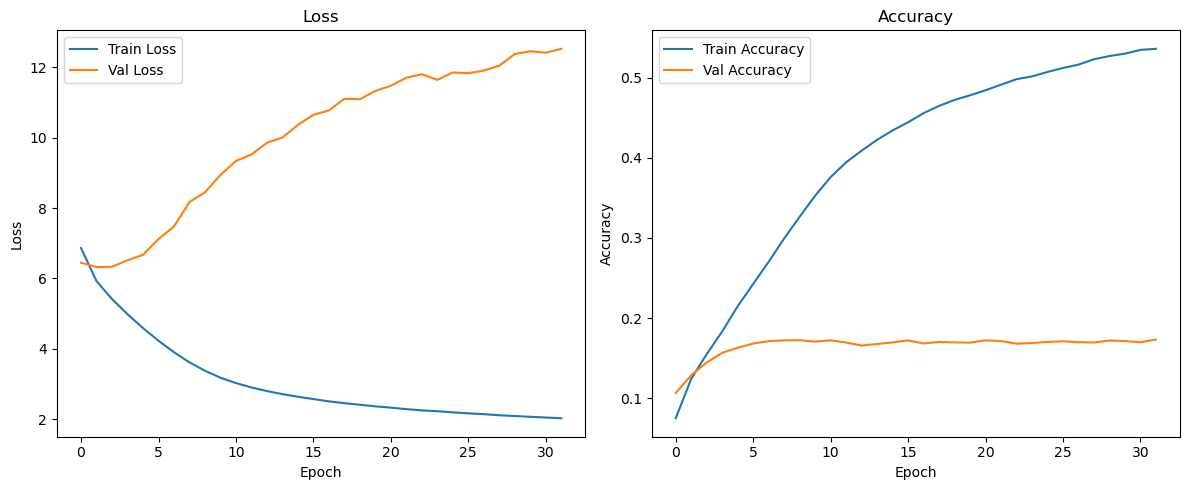

In [16]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Generate Jokes
- Function to generate joke completion given a prompt.

In [ ]:
def generate_joke(prompt, max_gen_len=30):
    cleaned = joke_preprocessor.clean_text(prompt)
    encoded = joke_preprocessor.encode(cleaned)
    for _ in range(max_gen_len):
        padded = pad_sequences([encoded], maxlen=max_seq_len, padding='pre')
        pred_probs = model.predict(padded, verbose=0)[0]
        # Use sampling instead of argmax for more variety
        next_idx = np.random.choice(len(pred_probs), p=pred_probs/np.sum(pred_probs))
        encoded.append(next_idx)
    return joke_preprocessor.decode(encoded)

### Try Joke Completion!
- Enter a joke prompt and let the model complete it.

In [19]:
prompt = "Why did the chicken cross the road?"
completed_joke = generate_joke(prompt)
print("Prompt:", prompt)
print("Generated joke:", completed_joke)

Prompt: Why did the chicken cross the road?
Generated joke: why did the chicken cross the road and says i dont know how many i dont know how many i dont know how many i dont know how many i dont know how many i dont know
